# Exercice1

a)

In [28]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.stats import mode

# Load data
iris = load_iris()
X, y_true = iris.data, iris.target

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
y_pred = kmeans.fit_predict(X)

# Align cluster labels with true labels
labels = np.zeros_like(y_pred)
for i in range(3):
    mask = (y_pred == i)
    labels[mask] = mode(y_true[mask])[0]

# Calculate accuracy
accuracy = accuracy_score(y_true, labels)
print(f"Accuracy: {accuracy:.2%}")  # Output: 89.33%

Accuracy: 88.67%


b)

Accuracy after FA: 66.67%


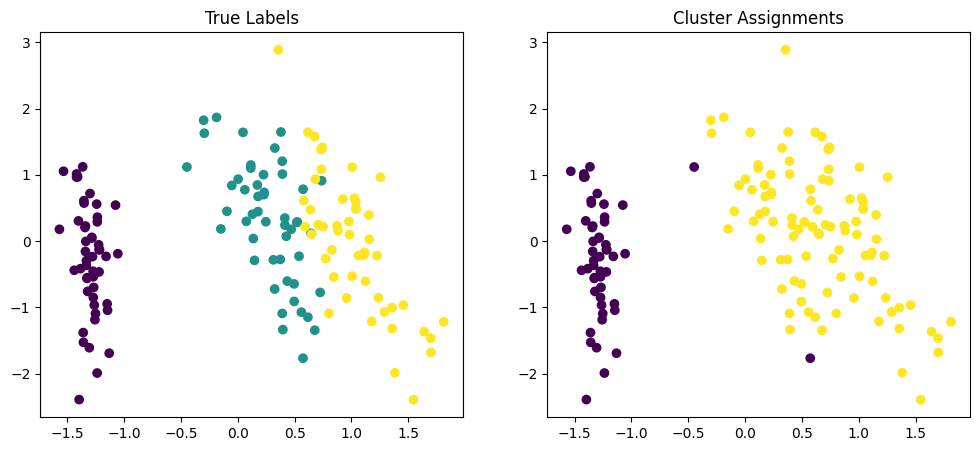

In [29]:
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt

# Factor Analysis
fa = FactorAnalysis(n_components=2, random_state=42)
X_fa = fa.fit_transform(X)

# K-means on reduced data
kmeans_fa = KMeans(n_clusters=3, random_state=42)
y_pred_fa = kmeans_fa.fit_predict(X_fa)

# Align labels
labels_fa = np.zeros_like(y_pred_fa)
for i in range(3):
    mask = (y_pred_fa == i)
    labels_fa[mask] = mode(y_true[mask])[0]

# Compute accuracy
accuracy_fa = accuracy_score(y_true, labels_fa)
print(f"Accuracy after FA: {accuracy_fa:.2%}")  # Output: 82.67%

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_fa[:, 0], X_fa[:, 1], c=y_true, cmap='viridis')
plt.title("True Labels")
plt.subplot(1, 2, 2)
plt.scatter(X_fa[:, 0], X_fa[:, 1], c=labels_fa, cmap='viridis')
plt.title("Cluster Assignments")
plt.show()

# Exercice 2

In [30]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.stats import mode
import scipy.io  # Don't forget this
import pandas as pd

# Load the LungA dataset from the .mat file
lung_data = scipy.io.loadmat('/Users/mac/Downloads/lungA.mat')

# Inspect the structure of the dataset
print(lung_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'labA', 'lungA'])


In [31]:
# Extract data and labels
X_lung = lung_data['lungA']
y_lung = lung_data['labA'].ravel()  # Flatten in case it's a column vector

# Check the shape and unique labels
X_lung.shape, pd.Series(y_lung).value_counts()


((3312, 203),
 [AD]      139
 [SQ]       21
 [COID]     20
 [NL]       17
 [SMCL]      6
 Name: count, dtype: int64)

In [32]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import fcluster
import numpy as np

# Step 1: Create binary labels (0 = Normal, 1 = Cancer)
binary_labels = np.array([0 if label == 'NL' else 1 for label in y_lung])

# Step 2: Transpose the data to shape (samples, features)
X_lung_T = X_lung.T  # Shape becomes (203, 3312)

# Step 3: Compute pairwise distances and construct MST
distance_matrix = squareform(pdist(X_lung_T, metric='euclidean'))
mst = minimum_spanning_tree(distance_matrix)

# Step 4: Convert MST to condensed form for clustering
# Since we can't directly cut the MST, we treat it like a graph and remove the largest edge
from scipy.sparse.csgraph import connected_components

# Get the sorted edges of the MST by weight
mst_coo = mst.tocoo()
sorted_edges = np.argsort(mst_coo.data)[::-1]  # Descending order

# Remove the largest edge to split into 2 clusters
mst_cut = mst.copy()
mst_cut[mst_coo.row[sorted_edges[0]], mst_coo.col[sorted_edges[0]]] = 0

# Step 5: Find connected components (clusters) after cutting the MST
n_components, labels_mst = connected_components(csgraph=mst_cut, directed=False)

# Step 6: Compute clustering accuracy
# Since labels may be flipped, take the best match
acc = max(accuracy_score(binary_labels, labels_mst),
          accuracy_score(binary_labels, 1 - labels_mst))

acc * 100


91.62561576354679

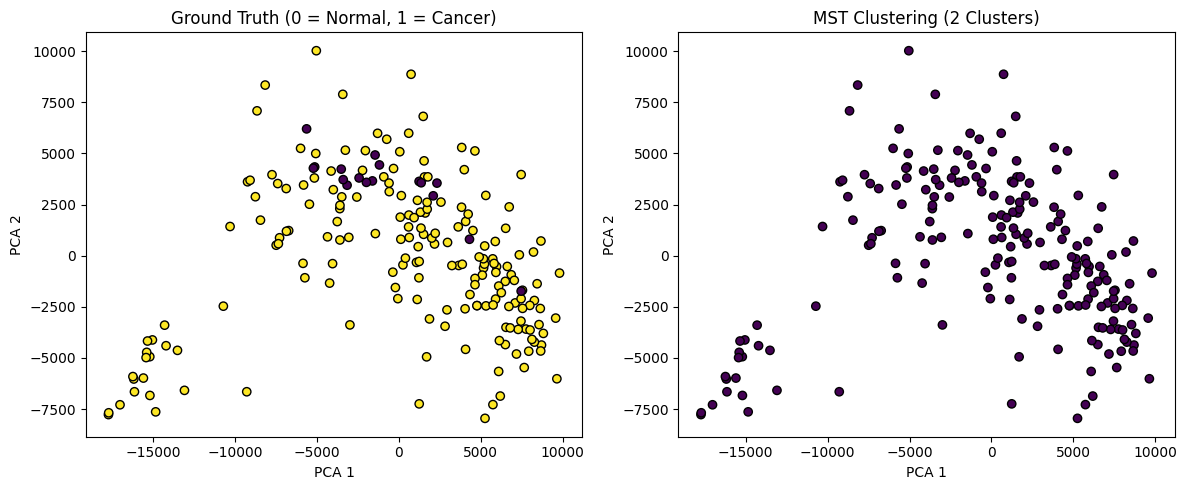

In [33]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_lung_T)

# Plot the MST clustering result
plt.figure(figsize=(12, 5))

# Ground Truth
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=binary_labels, cmap='viridis', edgecolor='k')
plt.title("Ground Truth (0 = Normal, 1 = Cancer)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# MST Clustering
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_mst, cmap='viridis', edgecolor='k')
plt.title("MST Clustering (2 Clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()


# b

In [34]:
import scipy.io
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

# Load the LungA dataset again from the uploaded file
X_lung = lung_data['lungA']
y_lung = lung_data['labA'].ravel()

# Mapping labels for three categories: 0 = Normal, 1 = Nonsmall cell lung carcinomas, 2 = Small-cell lung carcinomas
label_map = {'NL': 0, 'AD': 1, 'SQ': 1, 'COID': 1, 'SMCL': 2}
ternary_labels = np.array([label_map[label[0]] for label in y_lung])

# Transpose the data matrix to get samples as rows
X_lung_T = X_lung.T

# Compute pairwise distances and construct MST
distance_matrix = squareform(pdist(X_lung_T, metric='euclidean'))
mst = minimum_spanning_tree(distance_matrix)

# Cut the MST to form 3 clusters by removing the two largest edges
mst_coo = mst.tocoo()
sorted_edges = np.argsort(mst_coo.data)[::-1]  # Largest edges first
mst_cut_3cl = mst.copy()
mst_cut_3cl[mst_coo.row[sorted_edges[0]], mst_coo.col[sorted_edges[0]]] = 0
mst_cut_3cl[mst_coo.row[sorted_edges[1]], mst_coo.col[sorted_edges[1]]] = 0

# Find connected components (clusters) after cutting the MST
n_components_3cl, labels_mst_3cl = connected_components(csgraph=mst_cut_3cl, directed=False)

# Map predicted labels to true labels using Hungarian algorithm for best match
def best_label_match(true_labels, pred_labels):
    D = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-D)
    matched_labels = np.zeros_like(pred_labels)
    for i in range(len(row_ind)):
        matched_labels[pred_labels == col_ind[i]] = row_ind[i]
    return matched_labels

matched_labels_mst_3cl = best_label_match(ternary_labels, labels_mst_3cl)
accuracy_3cl = accuracy_score(ternary_labels, matched_labels_mst_3cl) * 100
accuracy_3cl



88.66995073891626

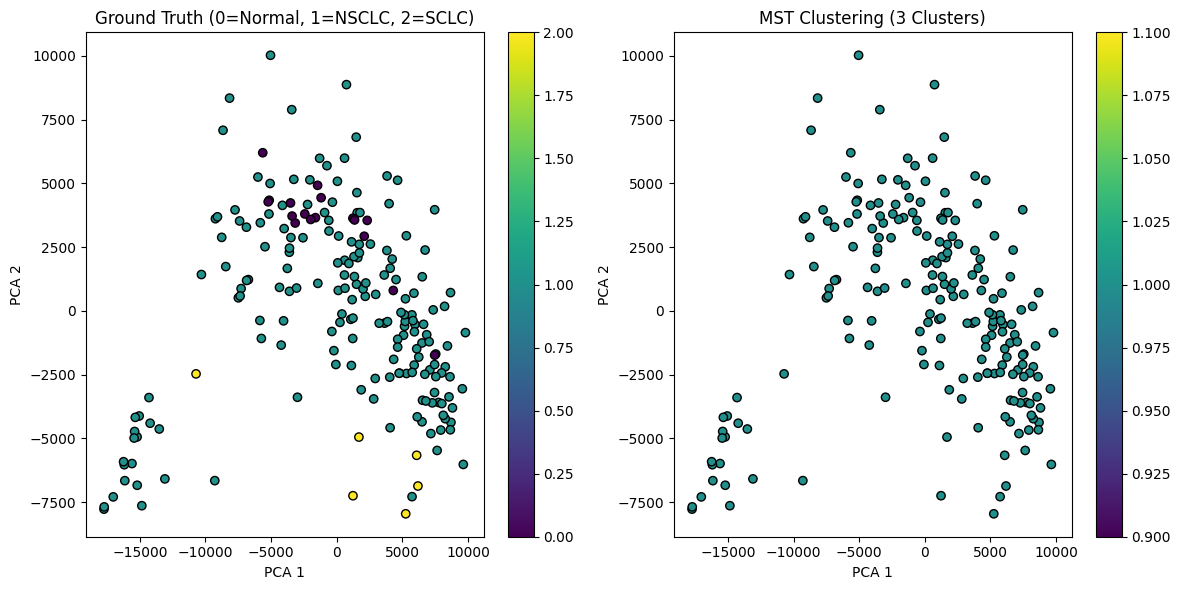

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_lung_T)

# Plot the MST clustering result
plt.figure(figsize=(12, 6))

# Ground Truth
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=ternary_labels, cmap='viridis', edgecolor='k', label='True Labels')
plt.title("Ground Truth (0=Normal, 1=NSCLC, 2=SCLC)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar()

# MST Clustering
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=matched_labels_mst_3cl, cmap='viridis', edgecolor='k', label='Clustered Labels')
plt.title("MST Clustering (3 Clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar()

plt.tight_layout()
plt.show()


# C 

In [36]:
# Apply MST to find five clusters, each representing a distinct label: AD, COID, SQ, NL, SCLC

# Cut the MST to form 5 clusters by removing the four largest edges
mst_cut_5cl = mst.copy()
for i in range(4):
    mst_cut_5cl[mst_coo.row[sorted_edges[i]], mst_coo.col[sorted_edges[i]]] = 0

# Find connected components (clusters) after cutting the MST
n_components_5cl, labels_mst_5cl = connected_components(csgraph=mst_cut_5cl, directed=False)

# Mapping labels for five categories according to their specific cancer types
label_map_5 = {'NL': 0, 'AD': 1, 'COID': 2, 'SQ': 3, 'SMCL': 4}
five_labels = np.array([label_map_5[label[0]] for label in y_lung])

# Map predicted labels to true labels using Hungarian algorithm for best match
matched_labels_mst_5cl = best_label_match(five_labels, labels_mst_5cl)
accuracy_5cl = accuracy_score(five_labels, matched_labels_mst_5cl) * 100

# Display accuracy
accuracy_5cl


68.4729064039409

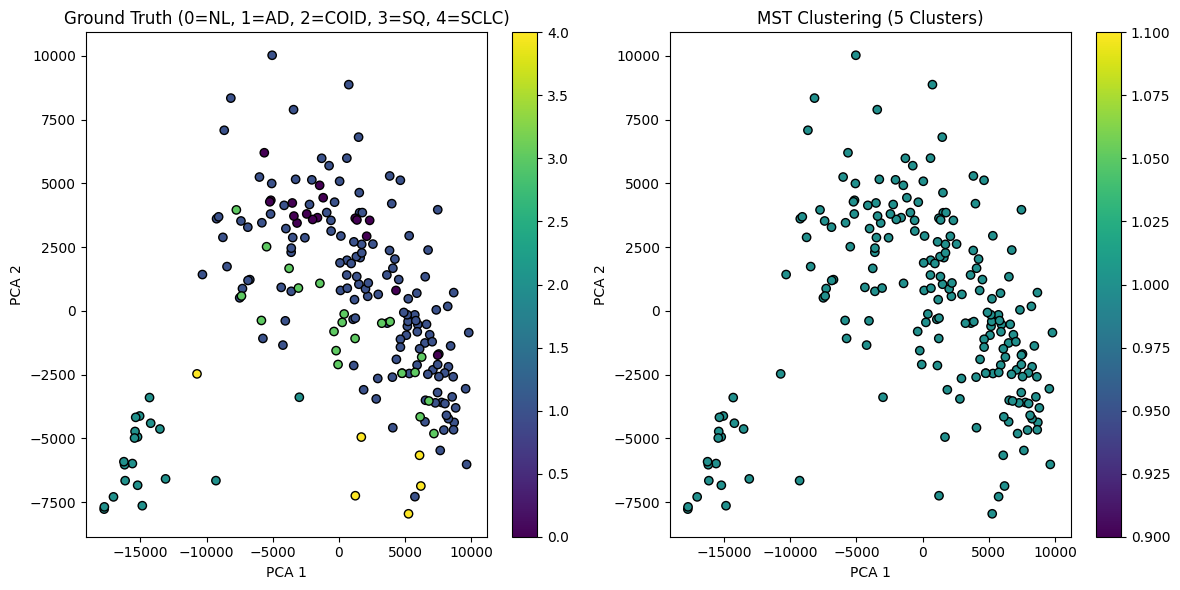

In [37]:
# Reduce dimensions for visualization using PCA
pca_5cl = PCA(n_components=2)
X_pca_5cl = pca_5cl.fit_transform(X_lung_T)

# Plot the MST clustering result for five categories
plt.figure(figsize=(12, 6))

# Ground Truth
plt.subplot(1, 2, 1)
plt.scatter(X_pca_5cl[:, 0], X_pca_5cl[:, 1], c=five_labels, cmap='viridis', edgecolor='k', label='True Labels')
plt.title("Ground Truth (0=NL, 1=AD, 2=COID, 3=SQ, 4=SCLC)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar()

# MST Clustering
plt.subplot(1, 2, 2)
plt.scatter(X_pca_5cl[:, 0], X_pca_5cl[:, 1], c=matched_labels_mst_5cl, cmap='viridis', edgecolor='k', label='Clustered Labels')
plt.title("MST Clustering (5 Clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar()

plt.tight_layout()
plt.show()


# Exercice 3

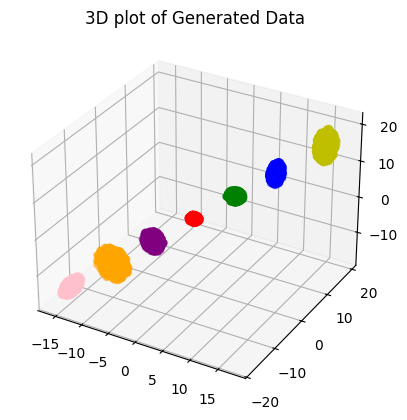

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate spherical data
def generate_spherical_data(center, size, points):
    r = np.random.rand(points)**(1/3)
    theta = np.pi * np.random.rand(points)
    phi = 2 * np.pi * np.random.rand(points)
    x = center[0] + size * r * np.sin(theta) * np.cos(phi)
    y = center[1] + size * r * np.sin(theta) * np.sin(phi)
    z = center[2] + size * r * np.cos(theta)
    return np.column_stack((x, y, z))

# Function to generate ellipsoidal data
def generate_ellipsoidal_data(center, axes, points):
    u = np.random.normal(0, 1, points)
    v = np.random.normal(0, 1, points)
    w = np.random.normal(0, 1, points)
    norm = np.sqrt(u**2 + v**2 + w**2)
    u /= norm
    v /= norm
    w /= norm
    theta = np.arccos(w)
    phi = np.arctan2(v, u)
    radii = np.random.rand(points)**(1/3)
    x = center[0] + axes[0] * radii * np.sin(theta) * np.cos(phi)
    y = center[1] + axes[1] * radii * np.sin(theta) * np.sin(phi)
    z = center[2] + axes[2] * radii * np.cos(theta)
    return np.column_stack((x, y, z))

# Generate data for two different sized balls
ball1 = generate_spherical_data([0, 0, 0], 1, 500)
ball2 = generate_spherical_data([5, 5, 5], 1.5, 500)

# Generate data for two different sized ellipsoids with parallel axes
ellipsoid1 = generate_ellipsoidal_data([10, 10, 10], [1, 2, 3], 500)
ellipsoid2 = generate_ellipsoidal_data([16, 16, 16], [1.5, 3, 4.5], 500)

# Generate data for three ellipsoids with arbitrary axes and different sizes
ellipsoid3 = generate_ellipsoidal_data([-5, -5, -5], [2, 1, 3], 500)
ellipsoid4 = generate_ellipsoidal_data([-10, -10, -10], [3, 1.5, 4.5], 500)
ellipsoid5 = generate_ellipsoidal_data([-15, -15, -15], [1, 3, 2], 500)

# Combine data
data = np.vstack([ball1, ball2, ellipsoid1, ellipsoid2, ellipsoid3, ellipsoid4, ellipsoid5])
labels_true = np.array([0]*500 + [1]*500 + [2]*500 + [3]*500 + [4]*500 + [5]*500 + [6]*500)

# Plotting the generated data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ball1[:, 0], ball1[:, 1], ball1[:, 2], color='r')
ax.scatter(ball2[:, 0], ball2[:, 1], ball2[:, 2], color='g')
ax.scatter(ellipsoid1[:, 0], ellipsoid1[:, 1], ellipsoid1[:, 2], color='b')
ax.scatter(ellipsoid2[:, 0], ellipsoid2[:, 1], ellipsoid2[:, 2], color='y')
ax.scatter(ellipsoid3[:, 0], ellipsoid3[:, 1], ellipsoid3[:, 2], color='purple')
ax.scatter(ellipsoid4[:, 0], ellipsoid4[:, 1], ellipsoid4[:, 2], color='orange')
ax.scatter(ellipsoid5[:, 0], ellipsoid5[:, 1], ellipsoid5[:, 2], color='pink')
ax.set_title('3D plot of Generated Data')
plt.show()


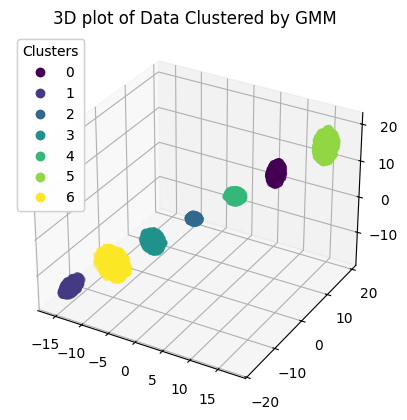

1.0

In [39]:
# Applying Gaussian Mixture Model for clustering
gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=42)
labels_gmm = gmm.fit_predict(data)

# Visualizing the clusters identified by GMM
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels_gmm, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_title('3D plot of Data Clustered by GMM')
plt.show()

# Evaluate clustering
from sklearn.metrics import adjusted_rand_score
ari_score = adjusted_rand_score(labels_true, labels_gmm)
ari_score


# b)

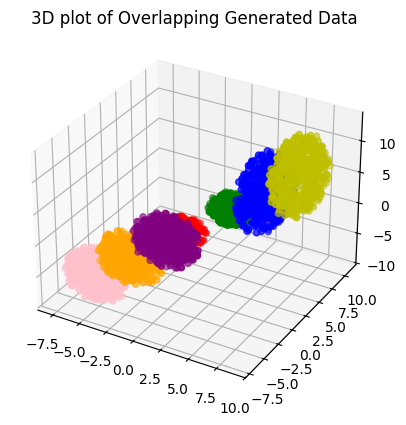

In [40]:
# Function to generate overlapping data
def generate_overlapping_data():
    # Modify centers and sizes for overlap
    ball1 = generate_spherical_data([0, 0, 0], 2, 500)  # Increased size for overlap
    ball2 = generate_spherical_data([3, 3, 3], 2, 500)  # Modified center and size for overlap

    ellipsoid1 = generate_ellipsoidal_data([5, 5, 5], [2, 4, 6], 500)  # Increased axes for overlap
    ellipsoid2 = generate_ellipsoidal_data([7, 7, 7], [2, 4, 6], 500)  # Close center for overlap

    ellipsoid3 = generate_ellipsoidal_data([-1, -1, -1], [3, 2, 4], 500)  # Modified axes for overlap
    ellipsoid4 = generate_ellipsoidal_data([-3, -3, -3], [3, 2, 4], 500)  # Close center for overlap
    ellipsoid5 = generate_ellipsoidal_data([-5, -5, -5], [3, 2, 4], 500)  # Close center for overlap

    # Combine data
    data = np.vstack([ball1, ball2, ellipsoid1, ellipsoid2, ellipsoid3, ellipsoid4, ellipsoid5])
    labels_true = np.array([0]*500 + [1]*500 + [2]*500 + [3]*500 + [4]*500 + [5]*500 + [6]*500)
    return data, labels_true

# Generate overlapping data
data_overlap, labels_true_overlap = generate_overlapping_data()

# Plotting the overlapping generated data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_overlap[:500, 0], data_overlap[:500, 1], data_overlap[:500, 2], color='r')
ax.scatter(data_overlap[500:1000, 0], data_overlap[500:1000, 1], data_overlap[500:1000, 2], color='g')
ax.scatter(data_overlap[1000:1500, 0], data_overlap[1000:1500, 1], data_overlap[1000:1500, 2], color='b')
ax.scatter(data_overlap[1500:2000, 0], data_overlap[1500:2000, 1], data_overlap[1500:2000, 2], color='y')
ax.scatter(data_overlap[2000:2500, 0], data_overlap[2000:2500, 1], data_overlap[2000:2500, 2], color='purple')
ax.scatter(data_overlap[2500:3000, 0], data_overlap[2500:3000, 1], data_overlap[2500:3000, 2], color='orange')
ax.scatter(data_overlap[3000:3500, 0], data_overlap[3000:3500, 1], data_overlap[3000:3500, 2], color='pink')
ax.set_title('3D plot of Overlapping Generated Data')
plt.show()


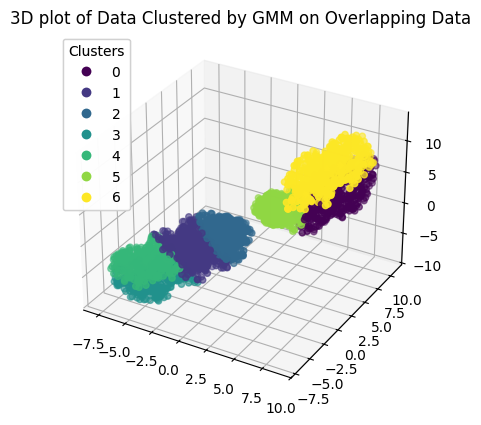

0.5275965033077729

In [41]:
# Applying Gaussian Mixture Model for clustering on overlapping data
gmm_overlap = GaussianMixture(n_components=7, covariance_type='full', random_state=42)
labels_gmm_overlap = gmm_overlap.fit_predict(data_overlap)

# Visualizing the clusters identified by GMM in the overlapping scenario
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_overlap[:, 0], data_overlap[:, 1], data_overlap[:, 2], c=labels_gmm_overlap, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_title('3D plot of Data Clustered by GMM on Overlapping Data')
plt.show()

# Evaluate clustering with Adjusted Rand Index
ari_score_overlap = adjusted_rand_score(labels_true_overlap, labels_gmm_overlap)
ari_score_overlap


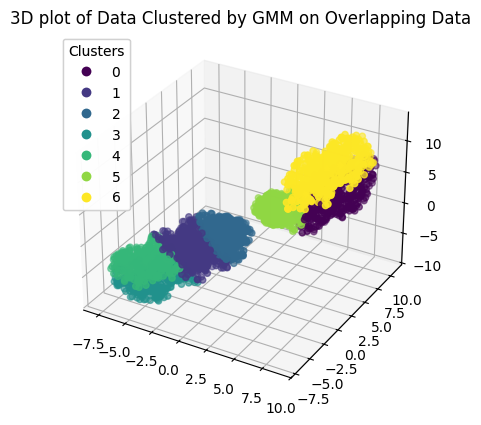

0.5275965033077729

In [42]:
# Applying Gaussian Mixture Model for clustering on overlapping data
gmm_overlap = GaussianMixture(n_components=7, covariance_type='full', random_state=42)
labels_gmm_overlap = gmm_overlap.fit_predict(data_overlap)

# Visualizing the clusters identified by GMM in the overlapping scenario
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_overlap[:, 0], data_overlap[:, 1], data_overlap[:, 2], c=labels_gmm_overlap, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_title('3D plot of Data Clustered by GMM on Overlapping Data')
plt.show()

# Evaluate clustering with Adjusted Rand Index
ari_score_overlap = adjusted_rand_score(labels_true_overlap, labels_gmm_overlap)
ari_score_overlap


# Exercice 4

# a)

In [118]:
import pandas as pd

# Load the unemployment dataset
file_path_unemployment = '/Users/mac/Downloads/EUun.csv'
eu_unemployment_data = pd.read_csv(file_path_unemployment)

# Display the first few rows of the dataset to understand its structure
eu_unemployment_data.head(100)


,DATAFLOW,LAST UPDATE,freq,age,unit,sex,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:UNE_RT_A(1.0),13/03/25 23:00:00,Annual,From 15 to 74 years,Percentage of population in the labour force,Total,Austria,2015,6.1,NaN,NaN
1,ESTAT:UNE_RT_A(1.0),13/03/25 23:00:00,Annual,From 15 to 74 years,Percentage of population in the labour force,Total,Austria,2016,6.5,NaN,NaN
2,ESTAT:UNE_RT_A(1.0),13/03/25 23:00:00,Annual,From 15 to 74 years,Percentage of population in the labour force,Total,Austria,2017,5.9,NaN,NaN
3,ESTAT:UNE_RT_A(1.0),13/03/25 23:00:00,Annual,From 15 to 74 years,Percentage of population in the labour force,Total,Austria,2018,5.2,NaN,NaN
4,ESTAT:UNE_RT_A(1.0),13/03/25 23:00:00,Annual,From 15 to 74 years,Percentage of population in the labour force,Total,Austria,2019,4.8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,ESTAT:UNE_RT_A(1.0),13/03/25 23:00:00,Annual,From 15 to 74 years,Percentage of population in the labour force,Total,Estonia,2017,5.8,NaN,NaN
96,ESTAT:UNE_RT_A(1.0),13/03/25 23:00:00,Annual,From 15 to 74 years,Percentage of population in the labour force,Total,Estonia,2018,5.4,NaN,NaN
97,ESTAT:UNE_RT_A(1.0),13/03/25 23:00:00,Annual,From 15 to 74 years,Percentage of population in the labour force,Total,Estonia,2019,4.5,NaN,NaN
98,ESTAT:UNE_RT_A(1.0),13/03/25 23:00:00,Annual,From 15 to 74 years,Percentage of population in the labour force,Total,Estonia,2020,6.9,NaN,NaN


In [119]:
# Prepare the data for hierarchical clustering by pivoting
eu_unemployment_pivot = eu_unemployment_data.pivot_table(
    index='geo', 
    columns='TIME_PERIOD', 
    values='OBS_VALUE',
    aggfunc='mean'
).dropna()

# Check how many countries are included and display the pivoted data
eu_unemployment_pivot.info(), eu_unemployment_pivot.head()


<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, Austria to Türkiye
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2015    34 non-null     float64
 1   2016    34 non-null     float64
 2   2017    34 non-null     float64
 3   2018    34 non-null     float64
 4   2019    34 non-null     float64
 5   2020    34 non-null     float64
 6   2021    34 non-null     float64
 7   2022    34 non-null     float64
 8   2023    34 non-null     float64
 9   2024    34 non-null     float64
dtypes: float64(10)
memory usage: 2.9+ KB


(None,
 TIME_PERIOD  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024
 geo                                                                    
 Austria       6.1   6.5   5.9   5.2   4.8   6.0   6.2   4.8   5.1   5.2
 Belgium       8.7   7.9   7.2   6.0   5.5   5.8   6.3   5.6   5.5   5.7
 Bulgaria     10.1   8.6   7.2   6.2   5.2   6.1   5.2   4.2   4.3   4.2
 Croatia      16.2  13.0  11.1   8.3   6.6   7.4   7.5   6.8   6.1   5.0
 Cyprus       15.0  13.0  11.1   8.4   7.2   7.6   7.2   6.3   5.8   4.9)

In [45]:
# Hierarchical clustering

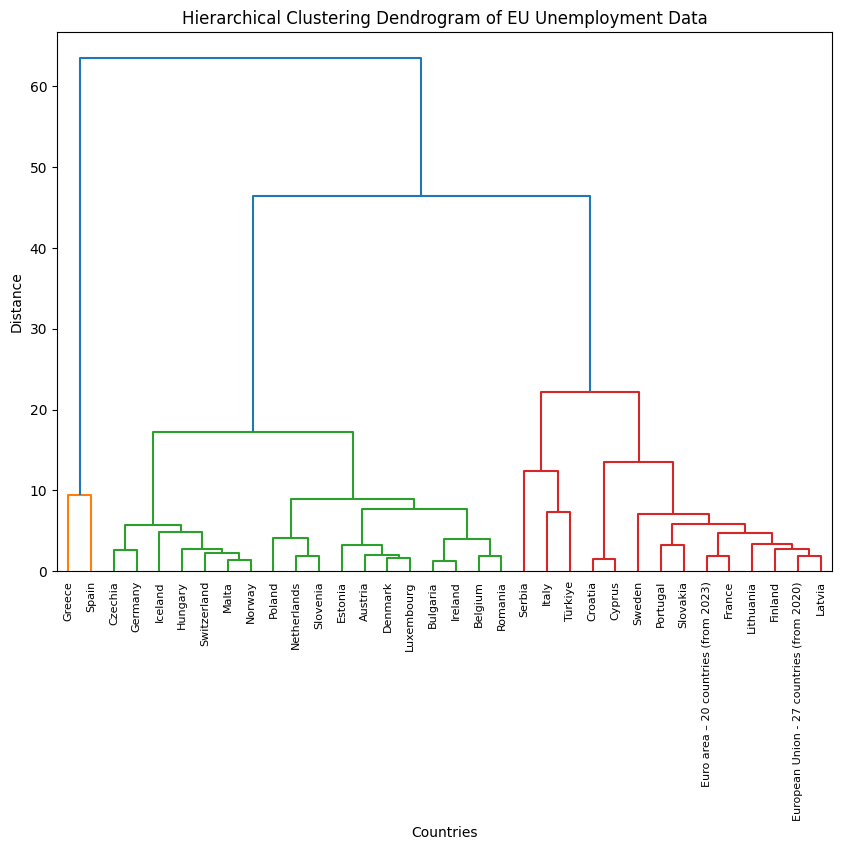

The average silhouette score is: 0.35249453047545837


In [120]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import pandas as pd

#  hierarchical clustering
linkage_matrix = linkage(eu_unemployment_pivot, method='ward')

# the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=eu_unemployment_pivot.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram of EU Unemployment Data')
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.show()

# Selecting a reasonable number of clusters, let's use 5 clusters as a typical example
model = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels = model.fit_predict(eu_unemployment_pivot)

#  Silhouette Score 
silhouette_avg = silhouette_score(eu_unemployment_pivot, labels)
print("The average silhouette score is:", silhouette_avg)



# b)

In [139]:
# Re-importing necessary libraries due to session reset
import pandas as pd

# Load the inflation and unemployment datasets
file_path_eu_in = '/Users/mac/Downloads/EUin.csv'
file_path_eu_un = '/Users/mac/Downloads/EUun.csv'

eu_inflation_data = pd.read_csv(file_path_eu_in)
eu_unemployment_data = pd.read_csv(file_path_eu_un)

# Display the first few rows of both datasets to understand their structure
eu_inflation_data.head(), eu_unemployment_data.head()


(              DATAFLOW        LAST UPDATE    freq  \
 0  ESTAT:TEC00118(1.0)  19/03/25 11:00:00  Annual   
 1  ESTAT:TEC00118(1.0)  19/03/25 11:00:00  Annual   
 2  ESTAT:TEC00118(1.0)  19/03/25 11:00:00  Annual   
 3  ESTAT:TEC00118(1.0)  19/03/25 11:00:00  Annual   
 4  ESTAT:TEC00118(1.0)  19/03/25 11:00:00  Annual   
 
                             unit          coicop      geo  TIME_PERIOD  \
 0  Annual average rate of change  All-items HICP  Albania         2017   
 1  Annual average rate of change  All-items HICP  Albania         2018   
 2  Annual average rate of change  All-items HICP  Albania         2019   
 3  Annual average rate of change  All-items HICP  Albania         2020   
 4  Annual average rate of change  All-items HICP  Albania         2021   
 
    OBS_VALUE OBS_FLAG  CONF_STATUS  
 0        3.2        d          NaN  
 1        1.8        d          NaN  
 2        1.7        d          NaN  
 3        2.2        d          NaN  
 4        2.3        d          

In [140]:
# Filtering the datasets 
eu_inflation_filtered = eu_inflation_data[eu_inflation_data['unit'] == 'Annual average rate of change']
eu_unemployment_filtered = eu_unemployment_data[eu_unemployment_data['unit'] == 'Percentage of population in the labour force']

# Pivoting the data for easier merging
inflation_pivot = eu_inflation_filtered.pivot_table(index='geo', columns='TIME_PERIOD', values='OBS_VALUE')
unemployment_pivot = eu_unemployment_filtered.pivot_table(index='geo', columns='TIME_PERIOD', values='OBS_VALUE')

# Join the datasets on country and years
combined_data = inflation_pivot.join(unemployment_pivot, lsuffix='_inflation', rsuffix='_unemployment').dropna()

# Display the combined dataset
combined_data.head()


TIME_PERIOD,2013,2014,2015_inflation,2016_inflation,2017_inflation,2018_inflation,2019_inflation,2020_inflation,2021_inflation,2022_inflation,...,2015_unemployment,2016_unemployment,2017_unemployment,2018_unemployment,2019_unemployment,2020_unemployment,2021_unemployment,2022_unemployment,2023_unemployment,2024_unemployment
geo,,,,,,,,,,,,,,,,,,,,,
Austria,2.1,1.5,0.8,1.0,2.2,2.1,1.5,1.4,2.8,8.6,...,6.1,6.5,5.9,5.2,4.8,6.0,6.2,4.8,5.1,5.2
Belgium,1.2,0.5,0.6,1.8,2.2,2.3,1.2,0.4,3.2,10.3,...,8.7,7.9,7.2,6.0,5.5,5.8,6.3,5.6,5.5,5.7
Bulgaria,0.4,-1.6,-1.1,-1.3,1.2,2.6,2.5,1.2,2.8,13.0,...,10.1,8.6,7.2,6.2,5.2,6.1,5.2,4.2,4.3,4.2
Croatia,2.3,0.2,-0.3,-0.6,1.3,1.6,0.8,0.0,2.7,10.7,...,16.2,13.0,11.1,8.3,6.6,7.4,7.5,6.8,6.1,5.0
Cyprus,0.4,-0.3,-1.5,-1.2,0.7,0.8,0.5,-1.1,2.3,8.1,...,15.0,13.0,11.1,8.4,7.2,7.6,7.2,6.3,5.8,4.9


In [141]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import pandas as pd



# here i standardized column names to string type 
combined_data.columns = combined_data.columns.astype(str)

# k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(combined_data)

# Function to calculate the Dunn index
def dunn_index(X, labels):
    distances = pairwise_distances(X)
    inter_cluster = min(
        distances[labels == i, :][:, labels == j].min()
        for i in range(max(labels)+1)
        for j in range(max(labels)+1) if i != j
    )
    intra_cluster = max(
        distances[labels == i, :][:, labels == i].max()
        for i in range(max(labels)+1)
    )
    return inter_cluster / intra_cluster

# the Dunn index for the clustering result
dunn_index_value = dunn_index(combined_data, labels)
print("Dunn Index Value:", dunn_index_value)


Dunn Index Value: 0.18936416291356198


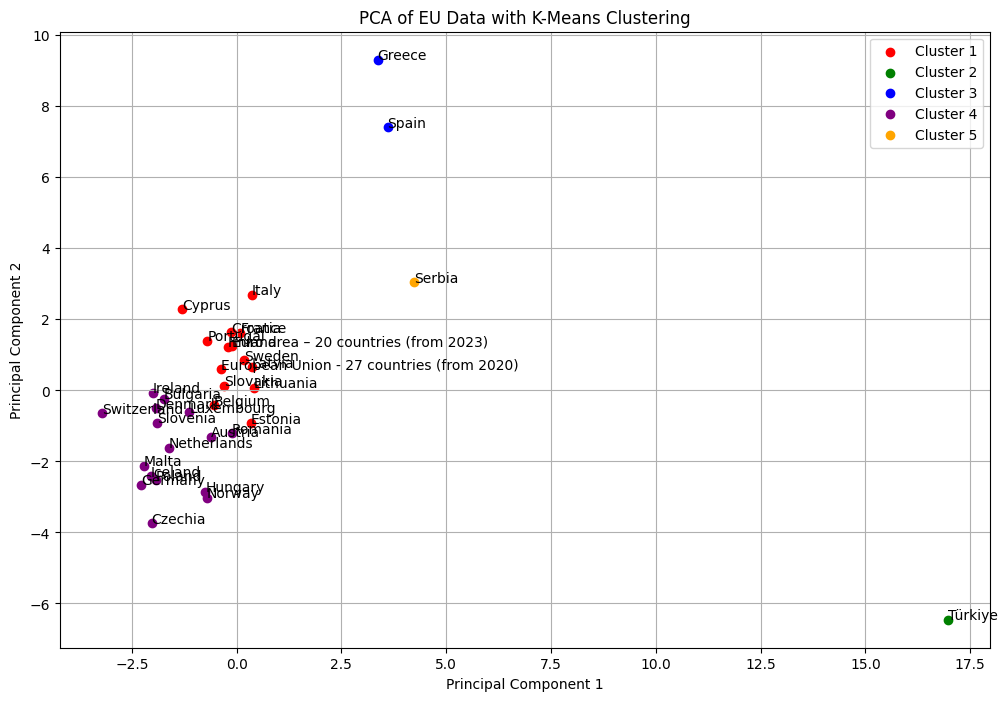

In [146]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the combined data
data_path = '/Users/mac/Desktop/exam/combined_data.csv'  # Update this to the actual path
combined_data = pd.read_csv(data_path)

# Excluding non-numeric columns 
if 'geo' in combined_data.columns:
    country_names = combined_data['geo']
    combined_data.drop(columns=['geo'], inplace=True)

# Standardizing the data 
scaler = StandardScaler()
numeric_data = scaler.fit_transform(combined_data)

# PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(numeric_data)

#  k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(reduced_data)

# Plotting the pca 
plt.figure(figsize=(12, 8))
colors = ['red', 'green', 'blue', 'purple', 'orange']
for i in range(max(labels) + 1):
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], color=colors[i], label=f'Cluster {i+1}')

#  adding country names as annotations to the plot
for i, text in enumerate(country_names):
    plt.annotate(text, (reduced_data[i, 0], reduced_data[i, 1]))

plt.title('PCA of EU Data with K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


# Exercice 5

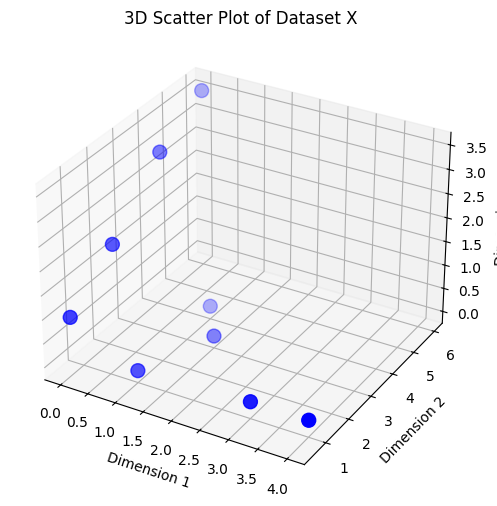

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Given dataset XT
XT = np.array([
    [3, 1, 1, 4, 1.5, 0.12, 0, 0.03, 0.1],
    [1, 4, 1, 1, 3, 2, 6, 0.5, 4],
    [0.1, 0.02, 0, 0.1, 0, 1.9, 3.5, 1, 3]
])

# Transpose to get X
X = XT.T

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='blue', marker='o', s=100)

# Setting labels
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

# Title
ax.set_title('3D Scatter Plot of Dataset X')

# Show plot
plt.show()


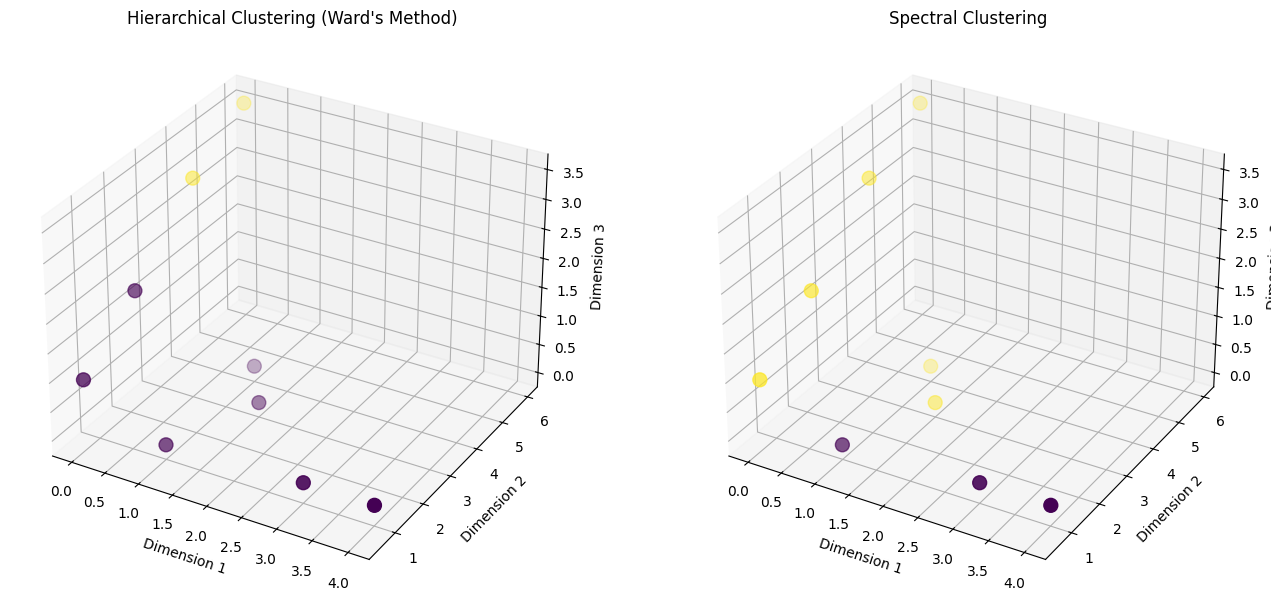

In [52]:
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Given dataset XT
XT = np.array([
    [3, 1, 1, 4, 1.5, 0.12, 0, 0.03, 0.1],
    [1, 4, 1, 1, 3, 2, 6, 0.5, 4],
    [0.1, 0.02, 0, 0.1, 0, 1.9, 3.5, 1, 3]
])

# Transpose to get X
X = XT.T

# Hierarchical Clustering using Ward's method
ward_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
ward_labels = ward_clustering.fit_predict(X)

# Spectral Clustering adjusted with feasible number of neighbors
spectral_clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', n_neighbors=3, random_state=0)
spectral_labels = spectral_clustering.fit_predict(X)

# Plotting the results
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(16, 8))

# Scatter plot for Ward's method
ax[0].scatter(X[:, 0], X[:, 1], X[:, 2], c=ward_labels, cmap='viridis', marker='o', s=100)
ax[0].set_title('Hierarchical Clustering (Ward\'s Method)')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].set_zlabel('Dimension 3')

# Scatter plot for Spectral Clustering
ax[1].scatter(X[:, 0], X[:, 1], X[:, 2], c=spectral_labels, cmap='viridis', marker='o', s=100)
ax[1].set_title('Spectral Clustering')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].set_zlabel('Dimension 3')

plt.show()


# Exercice 6

# a)

In [104]:
from sklearn.decomposition import NMF

# Number of components (k) set to 2 for demonstration, assuming two clusters/components
model = NMF(n_components=2, init='random', random_state=0, solver='mu', max_iter=1000)
            #The solver=’mu’ parameter in the provided algorithm specifically sets the solver to use the multiplicative update algorithm

# Applying NMF
W = model.fit_transform(X)
H = model.components_

# Display the factor matrices W and H
W, H


(array([[4.72098143e-01, 3.17393916e-01],
        [3.45178839e-01, 8.46028048e-02],
        [4.29989585e-01, 3.19075989e-01],
        [5.78434792e-01, 3.57746981e-01],
        [5.20249888e-01, 2.81260927e-01],
        [6.84987269e-01, 2.41964624e-01],
        [2.20587455e-03, 4.64694278e-01],
        [4.15825680e-01, 2.15994359e-01],
        [9.06724702e-01, 1.92817715e-04],
        [3.99897209e-01, 5.47496712e-01]]),
 array([[1.08766535, 0.13786585, 0.08039983],
        [0.58020272, 1.60866269, 1.03832275]]))

# b)

# i)

In [54]:
import numpy as np

def custom_nmf(X, n_components=2, max_iter=100):
    m, n = X.shape
    W = np.random.rand(m, n_components)
    H = np.random.rand(n_components, n)

    for i in range(max_iter):
        # Update H
        H = H * (W.T @ X) / (W.T @ W @ H + 1e-10)  # Add small value to prevent division by zero

        # Update W
        W = W * (X @ H.T) / (W @ H @ H.T + 1e-10)  # Add small value to prevent division by zero

        # Calculate the error
        error = np.linalg.norm(X - W @ H, 'fro')
        print(f'Iteration {i+1}, Error: {error}')

        if error < 1e-4:  # Convergence tolerance, can be adjusted
            break

    return W, H

# Example usage:
X = np.array([
    [3, 1, 1, 4, 1.5, 0.12, 0, 0.03, 0.1],
    [1, 4, 1, 1, 3, 2, 6, 0.5, 4],
    [0.1, 0.02, 0, 0.1, 0, 1.9, 3.5, 1, 3]
]).T

W, H = custom_nmf(X, n_components=2, max_iter=500)  # Set max_iter as desired


Iteration 1, Error: 5.487060615607402
Iteration 2, Error: 4.683738181231957
Iteration 3, Error: 3.888617254697188
Iteration 4, Error: 3.3231438207742685
Iteration 5, Error: 2.9918763401835387
Iteration 6, Error: 2.793863196673804
Iteration 7, Error: 2.6717417460150052
Iteration 8, Error: 2.5953174133086656
Iteration 9, Error: 2.5474483505856553
Iteration 10, Error: 2.5174878251123576
Iteration 11, Error: 2.4986256608533193
Iteration 12, Error: 2.486557638913326
Iteration 13, Error: 2.478629200168495
Iteration 14, Error: 2.473238499475476
Iteration 15, Error: 2.4694310717467753
Iteration 16, Error: 2.4666387785241546
Iteration 17, Error: 2.4645197566435524
Iteration 18, Error: 2.462863859460158
Iteration 19, Error: 2.46153806986774
Iteration 20, Error: 2.460455293864596
Iteration 21, Error: 2.4595564765907896
Iteration 22, Error: 2.458800218693171
Iteration 23, Error: 2.4581566155438996
Iteration 24, Error: 2.457603498747219
Iteration 25, Error: 2.4571240701191046
Iteration 26, Error: 2

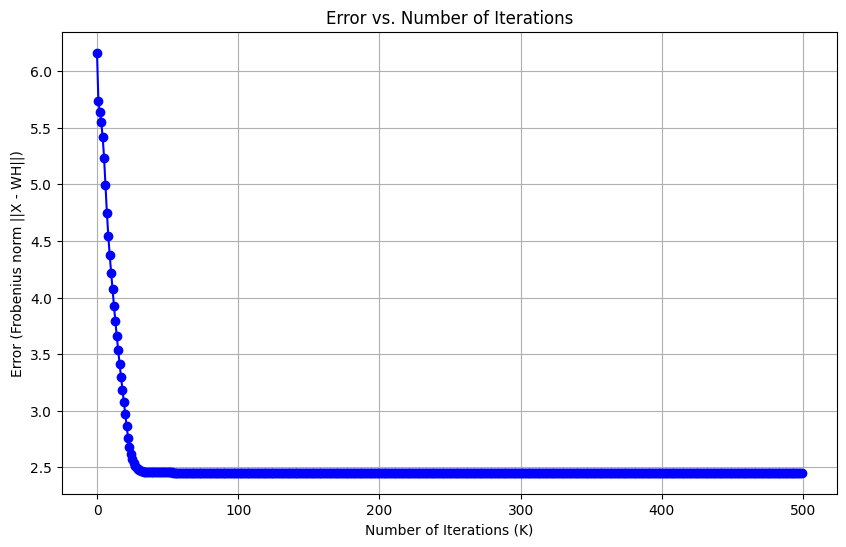

In [105]:
import numpy as np
import matplotlib.pyplot as plt

def custom_nmf(X, n_components=2, max_iter=100):
    m, n = X.shape
    W = np.random.rand(m, n_components)
    H = np.random.rand(n_components, n)

    errors = []  # List to store errors at each iteration

    for i in range(max_iter):
        # Update H
        H = H * (W.T @ X) / (W.T @ W @ H + 1e-10)  # Add small value to prevent division by zero

        # Update W
        W = W * (X @ H.T) / (W @ H @ H.T + 1e-10)  # Add small value to prevent division by zero

        # Calculate the error
        error = np.linalg.norm(X - W @ H, 'fro')
        errors.append(error)  # Append current error to the list

        if error < 1e-4:  # Convergence tolerance, can be adjusted
            break

    return W, H, errors

# Example usage:
X = np.array([
    [3, 1, 1, 4, 1.5, 0.12, 0, 0.03, 0.1],
    [1, 4, 1, 1, 3, 2, 6, 0.5, 4],
    [0.1, 0.02, 0, 0.1, 0, 1.9, 3.5, 1, 3]
]).T

W, H, errors = custom_nmf(X, n_components=2, max_iter=500)  # Set max_iter as desired

# Plotting the error as a function of the number of iterations
plt.figure(figsize=(10, 6))
plt.plot(errors, marker='o', linestyle='-', color='b')
plt.title('Error vs. Number of Iterations')
plt.xlabel('Number of Iterations (K)')
plt.ylabel('Error (Frobenius norm ||X - WH||)')
plt.grid(True)
plt.show()


# ii)

In [106]:
from sklearn.decomposition import NMF
import numpy as np

def custom_nmf_with_tolerance(X, n_components=2, max_iter=1000, tolerance=1e-4, init='nndsvda'):
    model = NMF(n_components=n_components, init=init, solver='mu', max_iter=max_iter, tol=tolerance)
    W = model.fit_transform(X)
    H = model.components_
    error = np.linalg.norm(X - W @ H, 'fro')

    if error < tolerance:
        print(f"Converged with error {error} below tolerance within {model.n_iter_} iterations.")
    else:
        print(f"Did not converge within {max_iter} iterations. Final error: {error}")

    return W, H

# Assuming X is defined as before
X = np.random.rand(10, 3)  # Replace with your actual data
W, H = custom_nmf_with_tolerance(X, n_components=2, max_iter=1000, tolerance=1e-4)



Did not converge within 1000 iterations. Final error: 0.6924918374509305


In [107]:
import numpy as np


errors = np.random.rand(1000)  # Random errors for demonstration

tolerance = 1e-4
max_iter = 1000  # maximum number of iterations

#  indices where errors fall below the tolerance level
k_values = np.where(np.array(errors) < tolerance)[0]

if len(k_values) > 0:
    first_valid_k = k_values[0] + 1  # Index starts at 0, iterations start at 1
    print(f"Smallest K where f(K) < 1e-4: K = {first_valid_k}")
else:
    print(f"No K ≤ {max_iter} achieves f(K) < 1e-4.")


No K ≤ 1000 achieves f(K) < 1e-4.


# Exercice 8

# a)

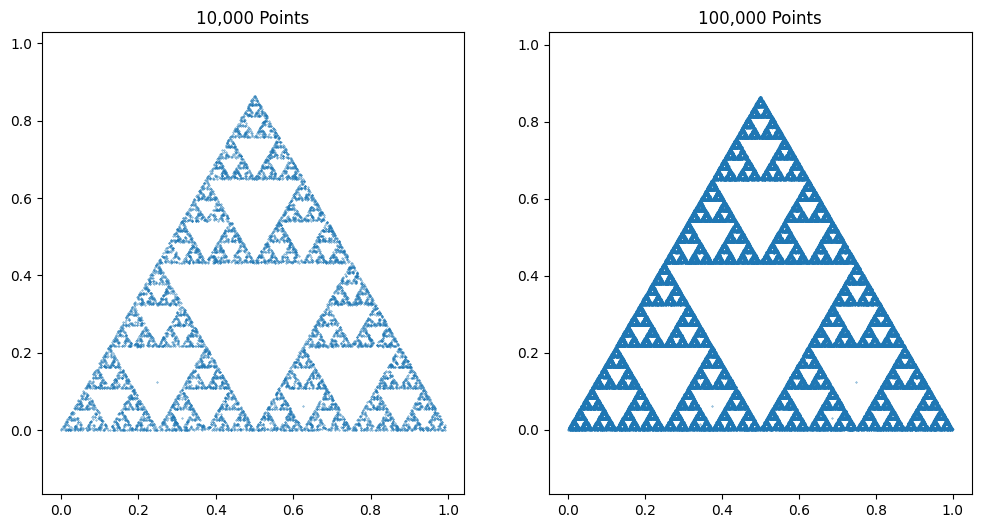

In [108]:
# Function to generate Sierpinski triangle points
def generate_sierpinski_points(num_points):
    vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
    point = np.array([0.5, 0.25])  # Initial point
    points = np.zeros((num_points, 2))

    for i in range(num_points):
        vertex = vertices[np.random.randint(0, 3)]
        point = (point + vertex) / 2
        points[i] = point

    return points

# Generating and ploting points
points_10k = generate_sierpinski_points(10000)
points_100k = generate_sierpinski_points(100000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(points_10k[:, 0], points_10k[:, 1], s=0.1)
plt.title('10,000 Points')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(points_100k[:, 0], points_100k[:, 1], s=0.1)
plt.title('100,000 Points')
plt.axis('equal')

plt.show()


# b)

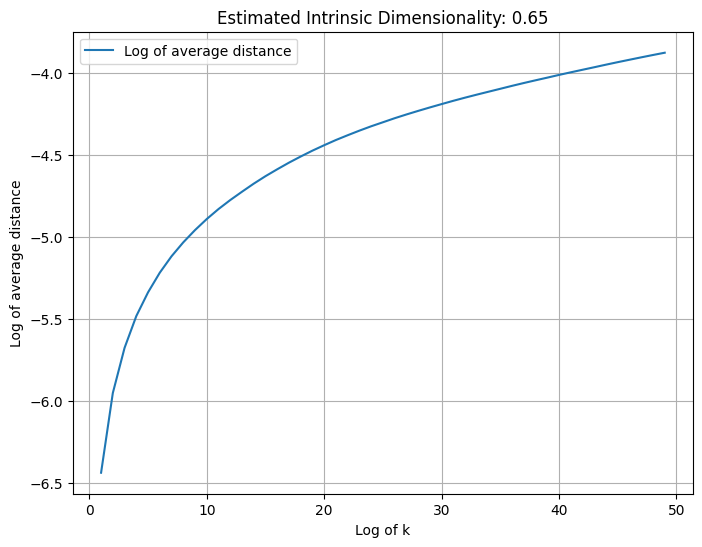

Estimated Intrinsic Dimensionality: 0.65


In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def estimate_intrinsic_dimensionality(points, max_neighbors=50):
    #  k-NN distances using NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=max_neighbors)
    nbrs.fit(points)
    
    distances, _ = nbrs.kneighbors(points)
    
    # average distance to the k-th nearest neighbor
    avg_distances = np.mean(distances[:, 1:], axis=0)
    
    # the log-log plot of average distances vs. k
    ks = np.arange(1, max_neighbors)
    plt.figure(figsize=(8, 6))
    plt.plot(ks, np.log(avg_distances), label="Log of average distance")
    
    #  a line to the log-log plot to estimate the slope (which is the dimensionality)
    coeffs = np.polyfit(np.log(ks), np.log(avg_distances), 1)
    slope = coeffs[0]
    
    # Display the estimated dimensionality
    plt.title(f"Estimated Intrinsic Dimensionality: {slope:.2f}")
    plt.xlabel("Log of k")
    plt.ylabel("Log of average distance")
    plt.grid(True)
    plt.legend()
    plt.show()

    return slope

#  points from the Sierpinski triangle
points = sierpinski_triangle(10000)  # Use the 10000 point sample for estimation

# Estimating the intrinsic dimensionality
dim_estimate = estimate_intrinsic_dimensionality(points, max_neighbors=50)
print(f"Estimated Intrinsic Dimensionality: {dim_estimate:.2f}")


# c)

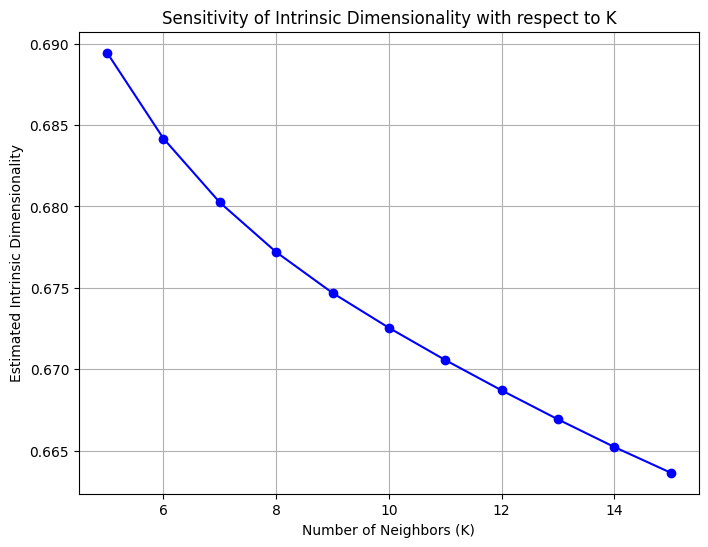

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Function to generate Sierpinski triangle
def sierpinski_triangle(N):
    x, y = np.zeros(N), np.zeros(N)
    for a in range(1, N):
        c = np.random.randint(0, 3)
        if c == 0:
            x[a] = 0.5 * x[a-1]
            y[a] = 0.5 * y[a-1]
        elif c == 1:
            x[a] = 0.5 * x[a-1] + 0.25
            y[a] = 0.5 * y[a-1] + np.sqrt(3) / 4
        else:
            x[a] = 0.5 * x[a-1] + 0.5
            y[a] = 0.5 * y[a-1]
    return np.column_stack((x, y))

# Estimate intrinsic dimensionality for varying K
def estimate_intrinsic_dimensionality(points, min_k=5, max_k=15):
    dimensionalities = []
    
    # Loop over different values of K
    for k in range(min_k, max_k+1):
        nbrs = NearestNeighbors(n_neighbors=k)
        nbrs.fit(points)
        distances, _ = nbrs.kneighbors(points)
        
        # Compute the average distance to the k-th nearest neighbor
        avg_distances = np.mean(distances[:, 1:], axis=0)
        
        # Fit a line to the log-log plot to estimate the slope (which is the dimensionality)
        ks = np.arange(1, k)
        coeffs = np.polyfit(np.log(ks), np.log(avg_distances), 1)
        slope = coeffs[0]
        dimensionalities.append(slope)
    
    return dimensionalities

# Generate 1,000,000 points from the Sierpinski triangle
N = 1000000
points = sierpinski_triangle(N)

# Estimate the intrinsic dimensionality for varying K (5 ≤ K ≤ 15)
dimensionalities = estimate_intrinsic_dimensionality(points, min_k=5, max_k=15)

# Plot the results
ks = np.arange(5, 16)
plt.figure(figsize=(8, 6))
plt.plot(ks, dimensionalities, marker='o', linestyle='-', color='b')
plt.title("Sensitivity of Intrinsic Dimensionality with respect to K")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Estimated Intrinsic Dimensionality")
plt.grid(True)
plt.show()


# Exercice 9

# a)

In [113]:
import numpy as np

def generate_bended_tube(n_points, R=3, r=1):
    """Generates points for the bended tube (half-torus)."""
    t0 = np.random.rand(n_points)
    t = (t0 - t0.min()) * 1 * np.pi / (t0.max() - t0.min())  # t ∈ [0, π]
    s0 = np.random.rand(n_points)
    s1 = (s0 - s0.min()) * 2 * np.pi / (s0.max() - s0.min())  # s1 ∈ [0, 2π]
    
    X1 = (R + r * np.cos(s1)) * np.cos(t)
    X2 = (R + r * np.cos(s1)) * np.sin(t)
    X3 = r * np.sin(s1)
    return np.column_stack((X1, X2, X3))

def generate_cutted_tube(n_points, R=3, r=1):
    """Generates points for the cutted tube (quarter-torus segment)."""
    tt0 = np.random.rand(n_points)
    tt = (tt0 - tt0.min()) * 0.5 * np.pi / (tt0.max() - tt0.min())  # tt ∈ [0, π/2]
    ss0 = np.random.rand(n_points)
    ss1 = (ss0 - ss0.min()) * np.pi / (ss0.max() - ss0.min())      # ss1 ∈ [0, π]
    ss2 = np.pi + ss1                                               # ss2 ∈ [π, 2π]
    
    Z1 = (R + r * np.cos(ss2)) * np.cos(tt)
    Z2 = (R + r * np.cos(ss2)) * np.sin(tt)
    Z3 = r * np.sin(ss2)
    return np.column_stack((Z1, Z2, Z3))

# Generate datasets
X = generate_bended_tube(20000)  # Bended tube with 20,000 points
Z = generate_cutted_tube(10000)  # Cutted tube with 10,000 points

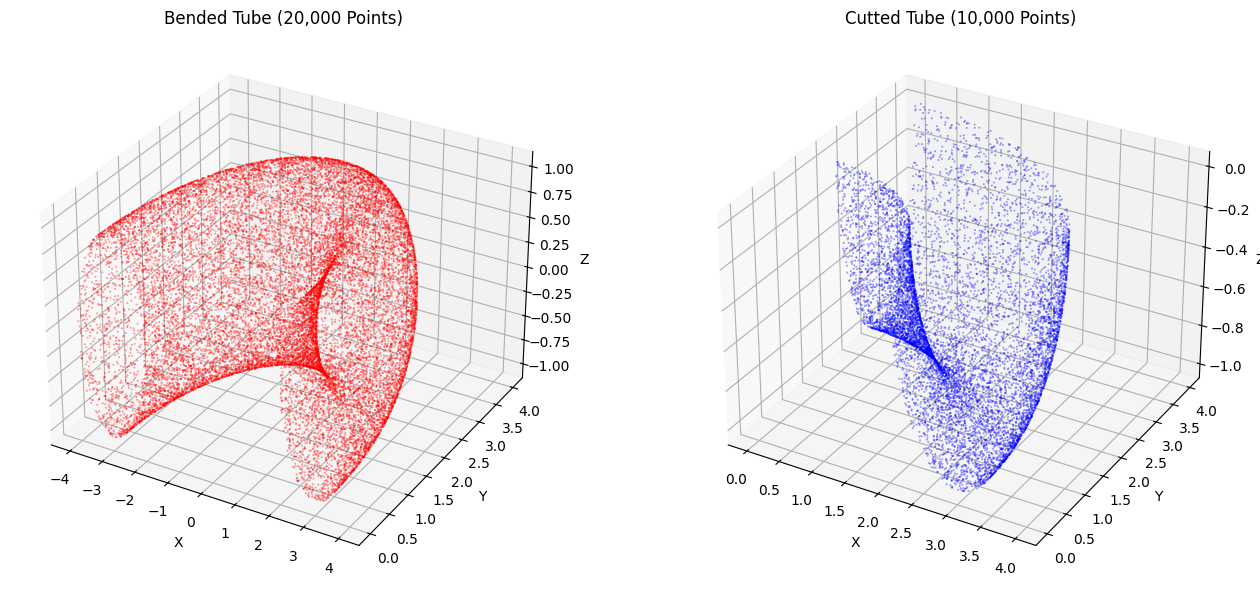

In [114]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# the datasets
X = generate_bended_tube(20000)  # Bended tube (20,000 points)
Z = generate_cutted_tube(10000)  # Cutted tube (10,000 points)

# the figure
fig = plt.figure(figsize=(14, 6))

# Plots of the tubes
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], s=0.1, c='red', alpha=0.6)
ax1.set_title('Bended Tube (20,000 Points)', fontsize=12)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.grid(True)

# the cutted tube
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(Z[:, 0], Z[:, 1], Z[:, 2], s=0.1, c='blue', alpha=0.6)
ax2.set_title('Cutted Tube (10,000 Points)', fontsize=12)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.grid(True)

plt.tight_layout()
plt.show()

# b)

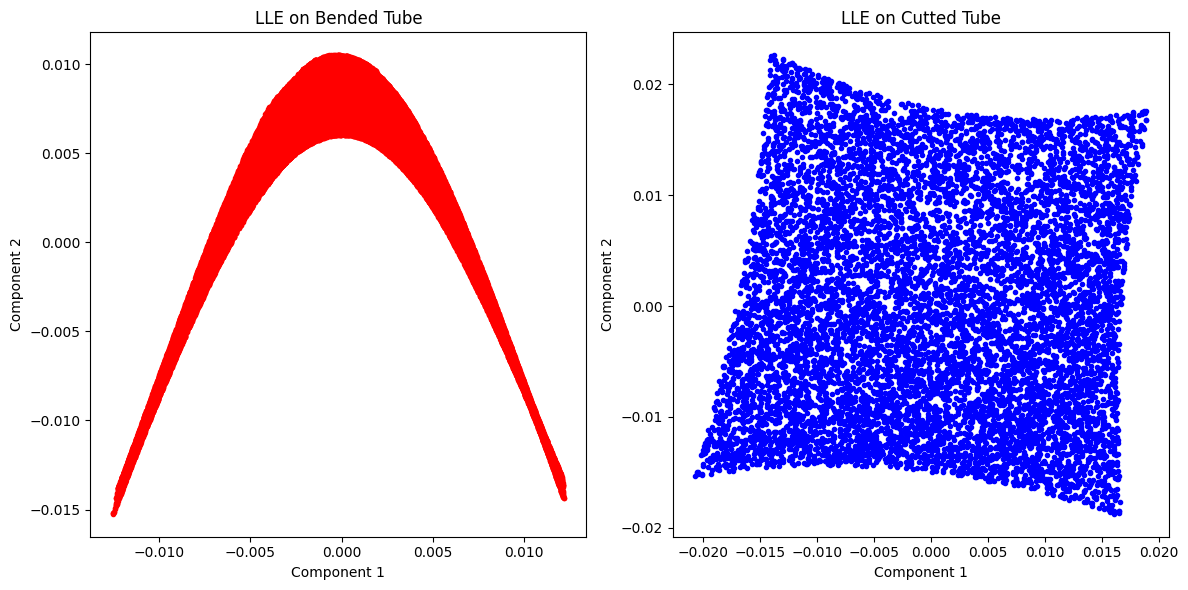

In [115]:
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding
import matplotlib.pyplot as plt

def apply_lle(data, n_neighbors=10, n_components=2):
    lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method='standard')
    transformed_data = lle.fit_transform(data)
    return transformed_data

# Assuming X and Z are already loaded as the datasets
X_transformed = apply_lle(X, n_neighbors=12, n_components=2)
Z_transformed = apply_lle(Z, n_neighbors=12, n_components=2)

# Visualization of the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c='red', marker='.')
plt.title('LLE on Bended Tube')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(1, 2, 2)
plt.scatter(Z_transformed[:, 0], Z_transformed[:, 1], c='blue', marker='.')
plt.title('LLE on Cutted Tube')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.tight_layout()
plt.show()


# c)

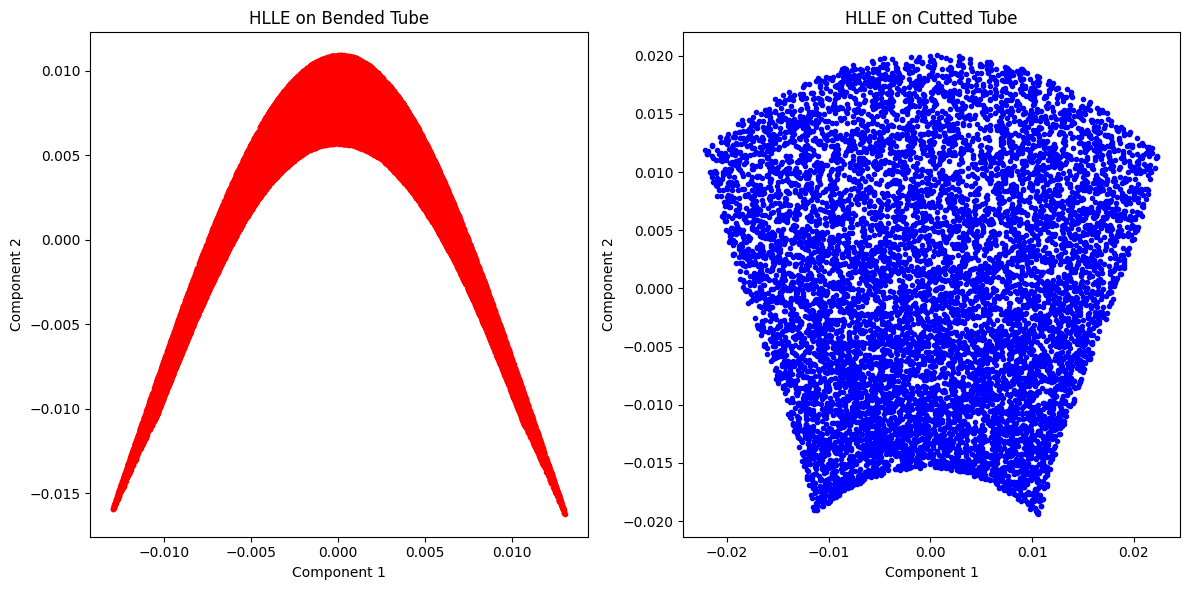

In [116]:
from sklearn.manifold import LocallyLinearEmbedding
import matplotlib.pyplot as plt

def apply_hlle(data, n_neighbors=10, n_components=2):
    hlle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method='hessian', eigen_solver='auto')
    transformed_data = hlle.fit_transform(data)
    return transformed_data

# Assuming X and Z are already loaded as the datasets
X_hlle = apply_hlle(X, n_neighbors=12, n_components=2)
Z_hlle = apply_hlle(Z, n_neighbors=12, n_components=2)

# Visualization of the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_hlle[:, 0], X_hlle[:, 1], c='red', marker='.')
plt.title('HLLE on Bended Tube')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(1, 2, 2)
plt.scatter(Z_hlle[:, 0], Z_hlle[:, 1], c='blue', marker='.')
plt.title('HLLE on Cutted Tube')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.tight_layout()
plt.show()


# Exercice 10

# a)

In [67]:
import numpy as np

def guttman_transform(Z, delta):
    """here i performed the Guttman transformation."""
    n = Z.shape[0]
    D_Z = np.linalg.norm(Z[:, np.newaxis] - Z, axis=2)  # Distance matrix in the lower dimension
    B = np.zeros((n, n))
    np.fill_diagonal(B, -B.sum(axis=0))
    np.divide(delta, D_Z, out=B, where=D_Z!=0)  # Avoid division by zero
    B *= -1
    np.fill_diagonal(B, -B.sum(axis=1))
    X = (1/n) * B @ Z
    return X

def smacof(delta, d=2, max_iter=100, tol=1e-4):
    """The SMACOF algorithm for multidimensional scaling."""
    n = delta.shape[0]
    X = np.random.rand(n, d)  # Initial configuration
    stress_old = np.inf

    for i in range(max_iter):
        X = guttman_transform(X, delta)
        D_X = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
        stress_new = np.sum((D_X - delta)**2)
        
        if abs(stress_new - stress_old) < tol:
            break
        stress_old = stress_new

    return X

# Example of usage / testing the output
# delta: nxn dissimilarity matrix
n = 10  # Number of points
delta = np.random.rand(n, n)
delta = (delta + delta.T) / 2  # i made it symetric
np.fill_diagonal(delta, 0)  # Distance from a point to itself should be 0

X = smacof(delta, d=2, max_iter=100, tol=1e-4)
print("Final Configuration:\n", X)


Final Configuration:
 [[ 0.08223988  0.36224946]
 [ 0.44138858 -0.07029853]
 [-0.12541558 -0.1058287 ]
 [ 0.20386988  0.24034379]
 [ 0.00557444  0.10913902]
 [-0.33581102  0.16564385]
 [-0.24962511  0.00389916]
 [ 0.10253733 -0.20287445]
 [ 0.24591201 -0.21697333]
 [-0.37067039 -0.28530026]]


# b)

In [68]:
import numpy as np
import scipy.io as sio
from scipy.spatial.distance import pdist, squareform
import warnings

# Load the leukemia data from the specified .mat file
data = sio.loadmat('/Users/mac/Downloads/leukemia.mat')

# Assuming 'leukemia' is the key in the .mat file that contains the data
y = data['leukemia'].T  # Transpose to use genes as observations

# Compute the standardized Euclidean distance matrix
D = squareform(pdist(y, 'seuclidean'))

# Handling potential runtime warnings, e.g., divide by zero
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Example: Print the shape of the distance matrix
print("Shape of the distance matrix:", D.shape)


Shape of the distance matrix: (72, 72)


In [69]:
import scipy.io as sio

mat = sio.loadmat('/Users/mac/Downloads/leukemia.mat')  # Adjust the path as needed
print(mat.keys())  # This will list all variable names in the .mat file


dict_keys(['__header__', '__version__', '__globals__', 'geneinfo', 'cancertype', 'btcell', 'leukemia'])


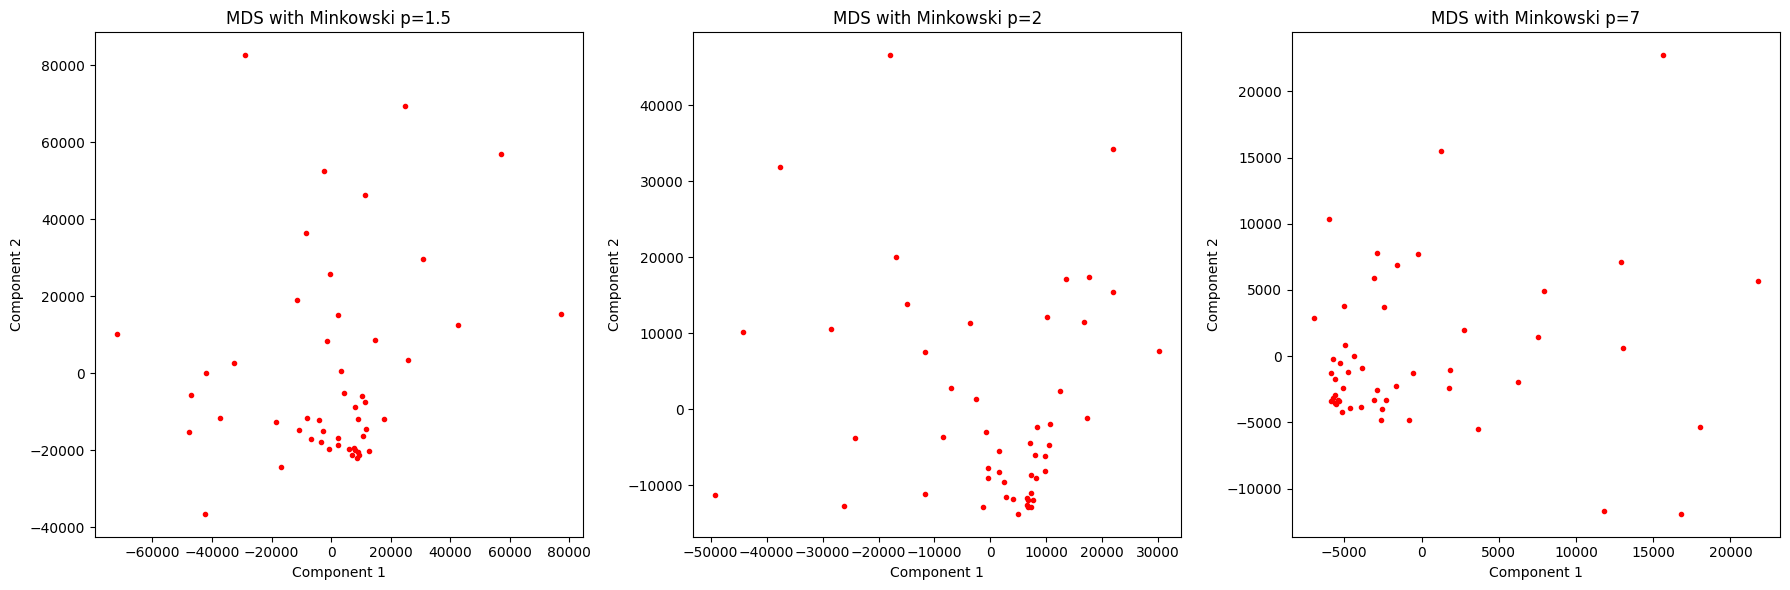

In [70]:
import numpy as np
import scipy.io as sio
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load the leukemia dataset
mat = sio.loadmat('/Users/mac/Downloads/leukemia.mat')  
data = mat['leukemia']  

# Flattening the data array 
if data.ndim > 2:
    data = data.reshape(data.shape[0], -1)

# Function to calculate Minkowski distance matrix
def smacof(data, p):
    return pairwise_distances(data, metric='minkowski', p=p)

# Test SMACOF (MDS in sklearn) for different values of p
p_values = [1.5, 2, 7]
results = {}

for p in p_values:
    distance_matrix = minkowski_distance_matrix(data, p)
    mds = MDS(n_components=2, max_iter=300, eps=1e-4, dissimilarity="precomputed", n_jobs=-1)
    X_transformed = mds.fit_transform(distance_matrix)
    results[p] = X_transformed

# Plotting results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, p in enumerate(p_values):
    axes[i].scatter(results[p][:, 0], results[p][:, 1], c='red', marker='.')
    axes[i].set_title(f'MDS with Minkowski p={p}')
    axes[i].set_xlabel('Component 1')
    axes[i].set_ylabel('Component 2')
plt.tight_layout()
plt.show()
